## Load the data

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import zipfile

# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extracted_path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras import layers, models
import matplotlib.pyplot as plt
import data_utils

In [ ]:
import os
import tensorflow as tf

# Define dataset paths
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Load datasets
train_ds, val_ds, class_names = data_utils.create_image_datasets(
    train_dir,
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)

print("Datasets loaded.")
print(f"Class names: {class_names}")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded.
Class names: ['Altered', 'Real']


In [ ]:
# Apply data augmentation
data_augmentation_layers = data_utils.get_data_augmentation_layers()
train_ds = data_utils.augment_dataset(train_ds, data_augmentation_layers)

# Prefetch datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Data augmentation applied and datasets prefetched.


## Train Base Model Augmentation

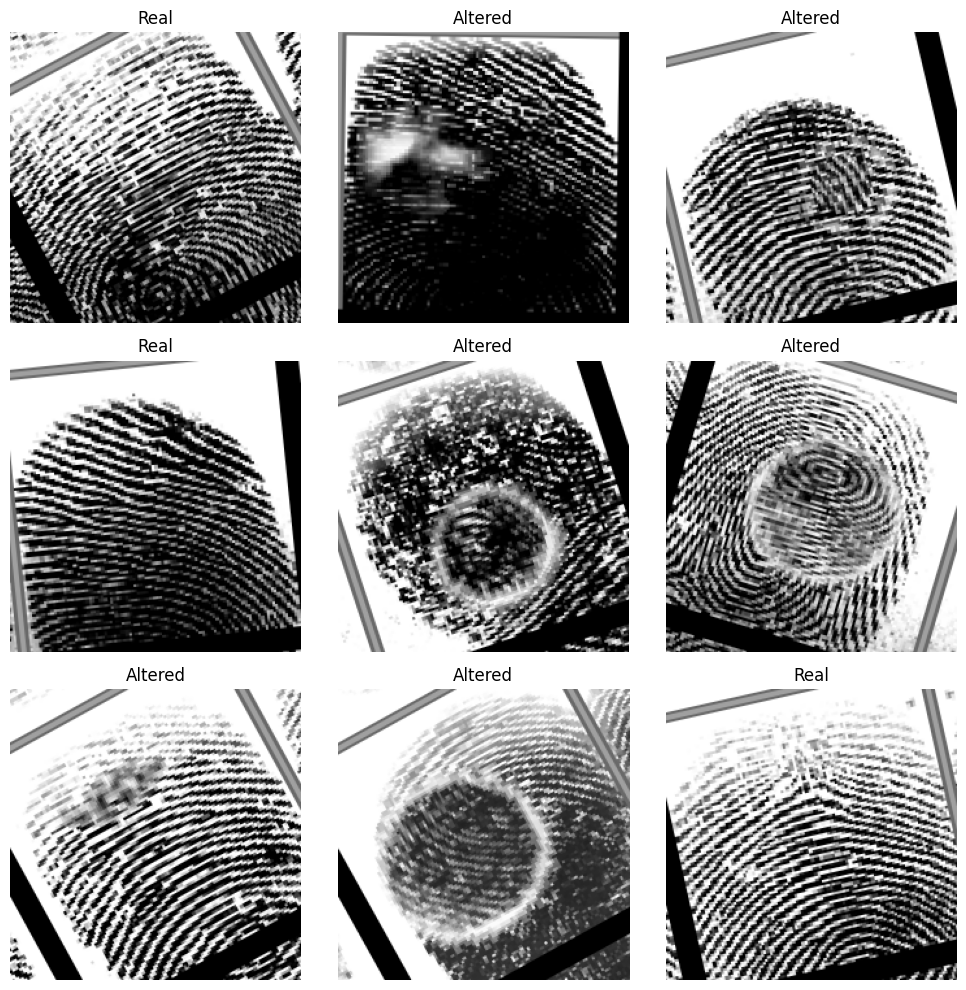

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Ensure images are in the correct format for plotting (uint8)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype("uint8")[0]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation=None)(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

Model compiled successfully.


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - acc: 0.4760 - loss: 0.8283 - val_acc: 0.5750 - val_loss: 0.6712
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - acc: 0.5259 - loss: 0.7701 - val_acc: 0.6000 - val_loss: 0.6555
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - acc: 0.5332 - loss: 0.7349 - val_acc: 0.6250 - val_loss: 0.6522
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.5898 - loss: 0.6606 - val_acc: 0.6250 - val_loss: 0.6411
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6207 - loss: 0.6088 - val_acc: 0.6500 - val_loss: 0.6284
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - acc: 0.6830 - loss: 0.5799 - val_acc: 0.6500 - val_loss: 0.6102
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.6753 - loss: 0.5847 - val_acc: 0.6250 - val_loss: 0.6067
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc: 0.6676 - loss: 0.5655 - val_acc: 0.6250 - val_loss: 0.5997
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - acc: 0.7447 - loss: 

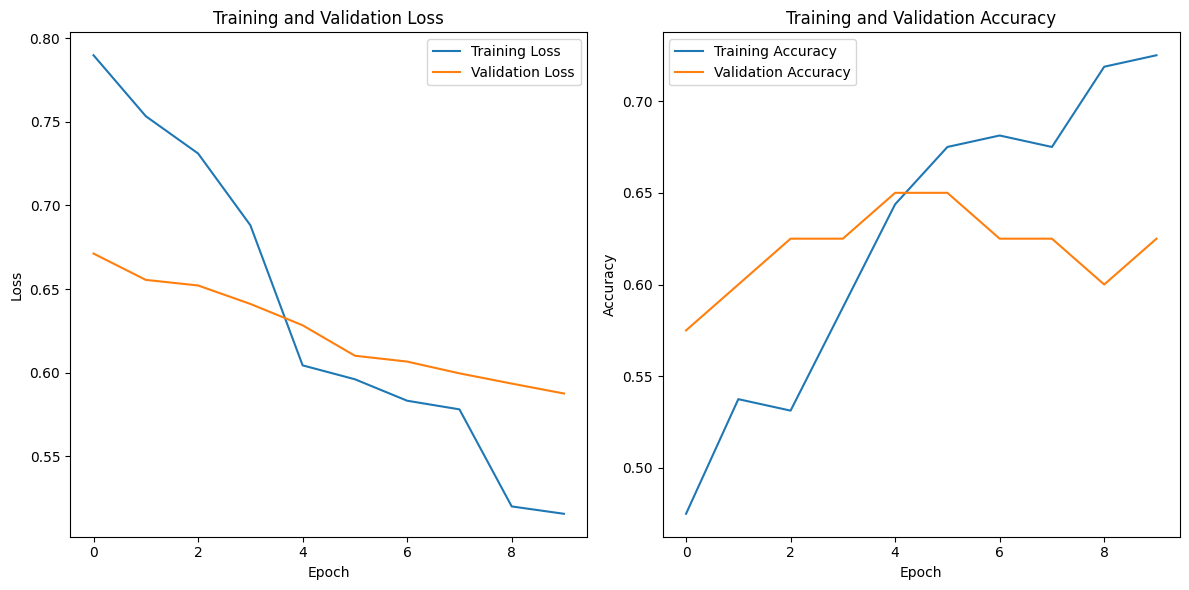

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('augmented_resnet50.keras')

### Summary:


*   A ResNet50 transfer learning model was built, with the base ResNet50 layers frozen and new layers added for binary classification. The model summary confirms that only the new layers are trainable.
*   The model was trained for 10 epochs using the augmented training data and validated on the validation data.
